In [1]:
#Explore one dataset
import xarray as xr
from pyproj import CRS

# Specify the path to your NetCDF file
file_path = r'C:\Users\fuentesm\Marilu\Deltares\Projects\Westerchelde\Data\S2A_MSI_2015_07_16_10_50_24_merged_westerschelde_L2W.nc'

# Open the NetCDF file with xarray
ds = xr.open_dataset(file_path)

# Create a new dataset excluding the specified variables
# variables_to_remove = ['transverse_mercator', 'x', 'y', 'lon', 'lat']
#ds= ds.drop_vars(variables_to_remove)

# Display the dataset information
variable_names = list(ds.variables)
print(variable_names)

# Replace 'your_crs_wkt' with the actual WKT representation of your CRS
# crs_wkt = 'PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ID["EPSG",6326]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]]],CONVERSION["UTM zone 31N",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",3,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natural origin",0.9996,SCALEUNIT["unity",1],ID["EPSG",8805]],PARAMETER["False easting",500000,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]],ID["EPSG",16031]],CS[Cartesian,2],AXIS["(E)",east,ORDER[1],LENGTHUNIT["metre",1,ID["EPSG",9001]]],AXIS["(N)",north,ORDER[2],LENGTHUNIT["metre",1,ID["EPSG",9001]]]]'
crs_wkt = ds.transverse_mercator.attrs['crs_wkt']
# Create a CRS object from the WKT representation
crs = CRS.from_string(crs_wkt)

# Get the EPSG code
epsg_code = crs.to_epsg()

# Print the EPSG code
print(f"EPSG code: {epsg_code}")

['transverse_mercator', 'x', 'y', 'lon', 'lat', 'l2_flags', 'chl_re_gons']
EPSG code: 32631


In [3]:
# Get stations_geometries_and_table
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium

def create_gdf(df):
    # Create GeoPoints with WGS 84 (EPSG:4326) coordinates
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

    # Create a GeoDataFrame with the GeoPoints
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

    # Reproject to a suitable projection for the Netherlands (e.g., Amersfoort / RD New, EPSG:28992)
    gdf = gdf.to_crs("EPSG:4326")

    # Display the GeoDataFrame
    return gdf

def display_map(gdf):
    # Get the center of the map based on the points
    center_lat, center_lon = gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()

    # Create a Folium map centered at the mean coordinates
    mymap = folium.Map(location=[center_lat, center_lon], zoom_start=10)

    # Add the GeoPoints to the map
    # for idx, row in gdf.iterrows():
    #     folium.Marker([row.geometry.y, row.geometry.x], popup=f"Point {idx}").add_to(mymap)

    # Add Circle markers to the map
    for idx, row in gdf.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=5,  # Adjust the radius as needed
            color='blue',  # Circle color
            fill=True,
            fill_color='blue',  # Fill color
            fill_opacity=0.6,
            popup=f"Point {idx}"
        ).add_to(mymap)

    # Display the map
    return mymap

def save_ponts(gdf, output_file):
    # Save the GeoDataFrame as GeoJSON
    gdf.to_file(output_file, driver='GeoJSON')

# Define stations csv file
file_path = r'P:\11209243-eo\Window_extraction\INPUT\stationLocations_oppWater.csv'
#file_path = r'P:\11209243-eo\Window_extraction\INPUT\stationLocations_oppWater.csv'
output_file = r'OUTPUT\points_stations.geojson'

# Read stations csv file
df  = pd.read_csv(file_path, sep=';')

# Create geometry and save the points as geojson
gdf = create_gdf(df)
save_ponts(gdf, 'points_stations.geojson')

# Display map. Only available in jupyter notebooks
mymap = display_map(gdf)
mymap


C:\Users\fuentesm\AppData\Local\Temp\ipykernel_15280\4127781489.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat, center_lon = gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()


In [5]:
# Get area geometries
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium

def get_polygons(df, x_column, y_column, group_column):
    # Create GeoPoints with WGS 84 (EPSG:4326) coordinates
    geometry = [Point(xy) for xy in zip(df['POINT_X'], df['POINT_Y'])]

    # Create a GeoDataFrame with the GeoPoints
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:28992")

    # Reproject to a suitable projection for the Netherlands (e.g., Amersfoort / RD New, EPSG:28992)
    gdf = gdf.to_crs("EPSG:4326")

    # Define column that indicates the groups of polygons 
        
    gdf['Group'] = gdf['CompNr'] 

    # Create a dictionary to store polygons based on group values
    polygons = {}

    # Iterate over unique group values and create polygons
    for group_value in range(1, 10):
        group_points = gdf[gdf['Group'] == group_value]
        
        # Ensure there are at least three points to form a polygon
        if len(group_points) >= 3:
            # Create a Polygon from the points
            polygon = Polygon(group_points['geometry'])
            polygons[group_value] = polygon

    # Create a new GeoDataFrame with the created Polygons
    polygons_gdf = gpd.GeoDataFrame({'Group': list(polygons.keys()), 'geometry': list(polygons.values())},
                                    geometry='geometry', crs="EPSG:4326")

    return polygons_gdf

def display_map(gdf):
    # Get the center of the map based on the points
    center_lat, center_lon = gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()

    # Create a Folium map centered at the mean coordinates
    mymap = folium.Map(location=[center_lat, center_lon], zoom_start=10)

    # Add Polygons to the map
    for idx, row in polygons_gdf.iterrows():
        folium.GeoJson(row['geometry'].__geo_interface__, popup=f"Group {row['Group']}").add_to(mymap)

    return mymap

def save_polygons(gdf, output_file):
    # Save the GeoDataFrame as GeoJSON
    polygons_gdf.to_file(output_file, driver='GeoJSON')

# Define polygons csv file and output geojson file
file_path = r'P:\11209243-eo\Window_extraction\INPUT\vakkenBewerkt.csv'
output_file = r'P:\11209243-eo\Window_extraction\OUTPUT\polygons_NEOZ.geojson'

# Read polygons csv file
df = pd.read_csv(file_path)

# Create geometries
polygons_gdf = get_polygons(df, 'POINT_X', 'POINT_Y', 'CompNr')

# Save geometries
save_polygons(polygons_gdf, output_file)

# Display geometries
mymap = display_map(gdf)
mymap


C:\Users\fuentesm\AppData\Local\Temp\ipykernel_15280\4071413391.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat, center_lon = gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()


['l2_flags', 'chl_re_gons']
['l2_flags', 'chl_re_gons']
['chl_re_gons', 'l2_flags']

chl_re_gons

C:/Users/fuentesm/Marilu/Deltares/Projects/Westerchelde/Data/S2A_MSI_2015_07_16_10_50_24_merged_westerschelde_L2W.nc


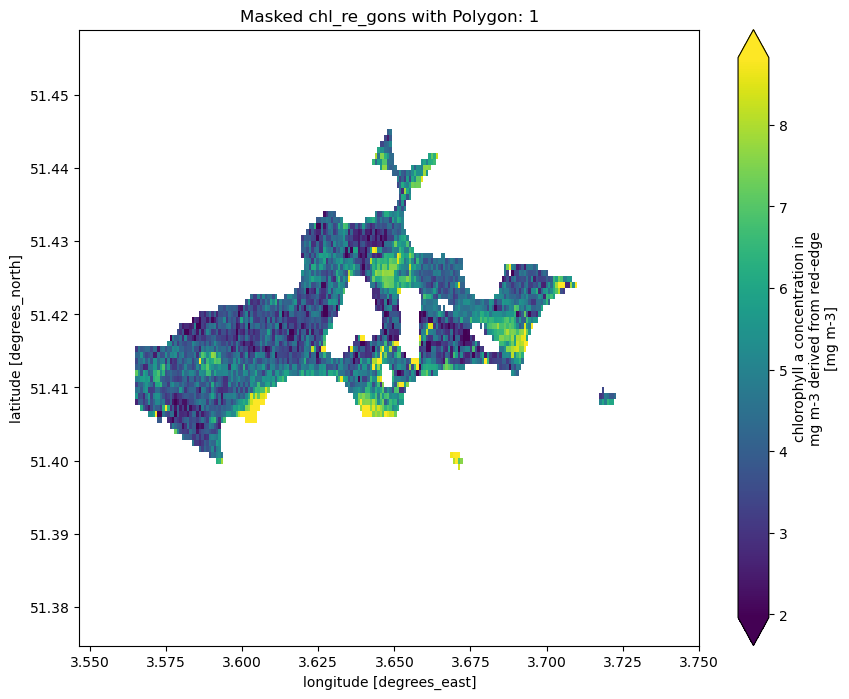

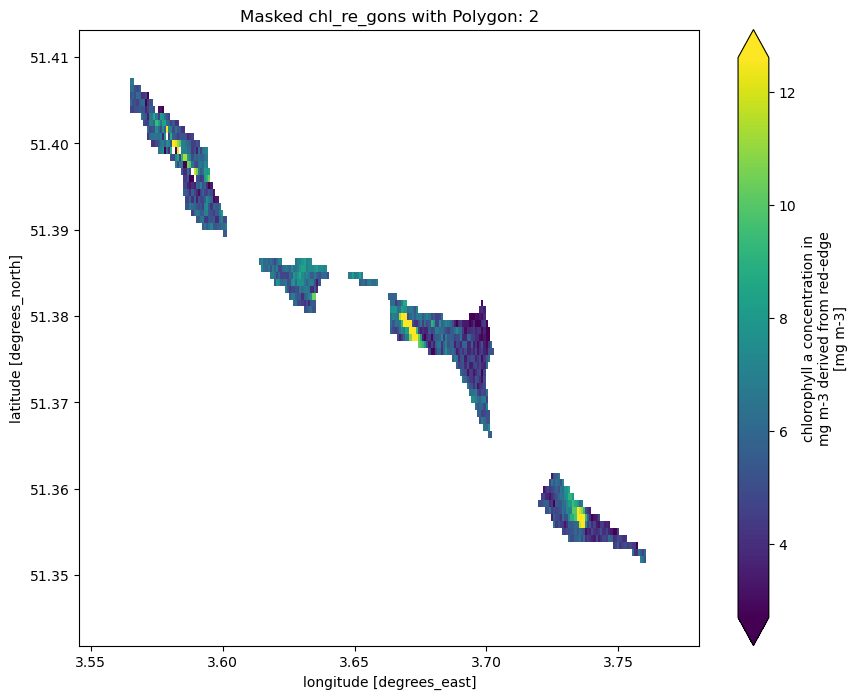

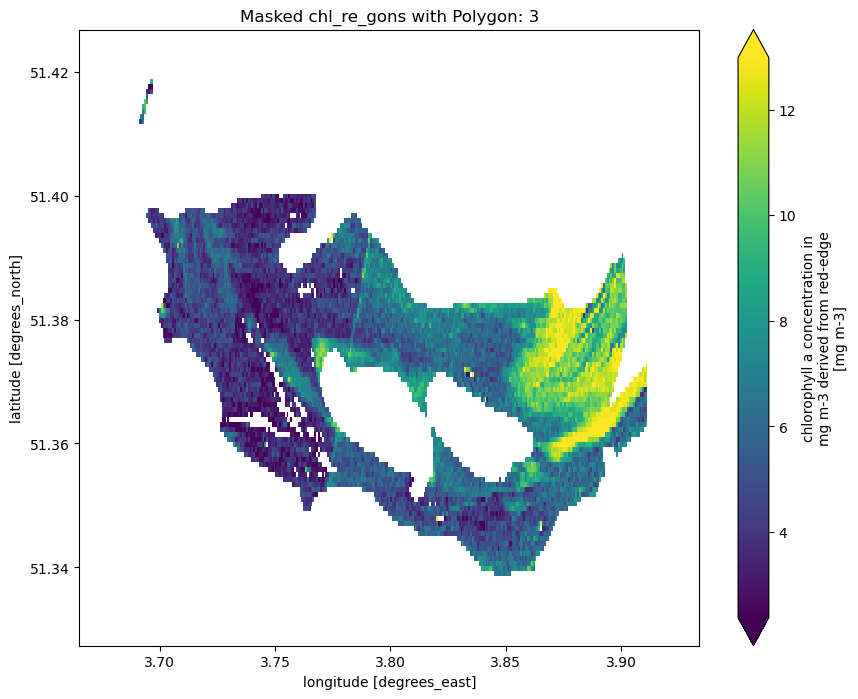

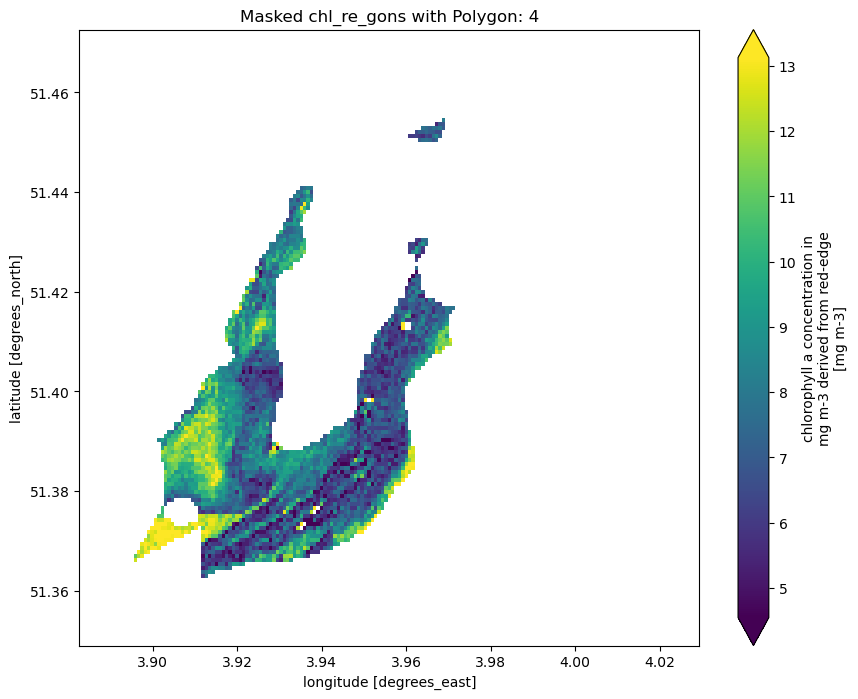

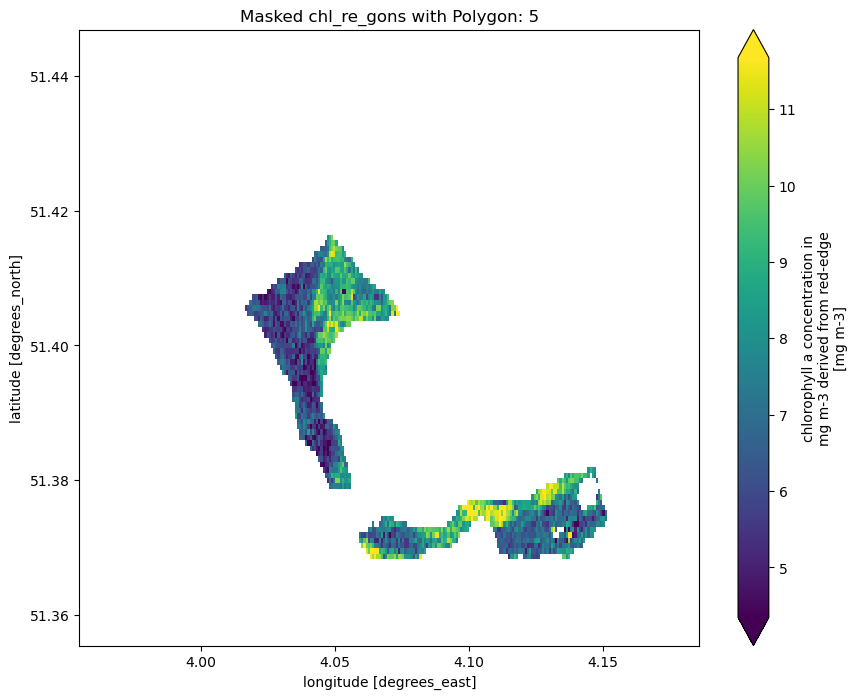

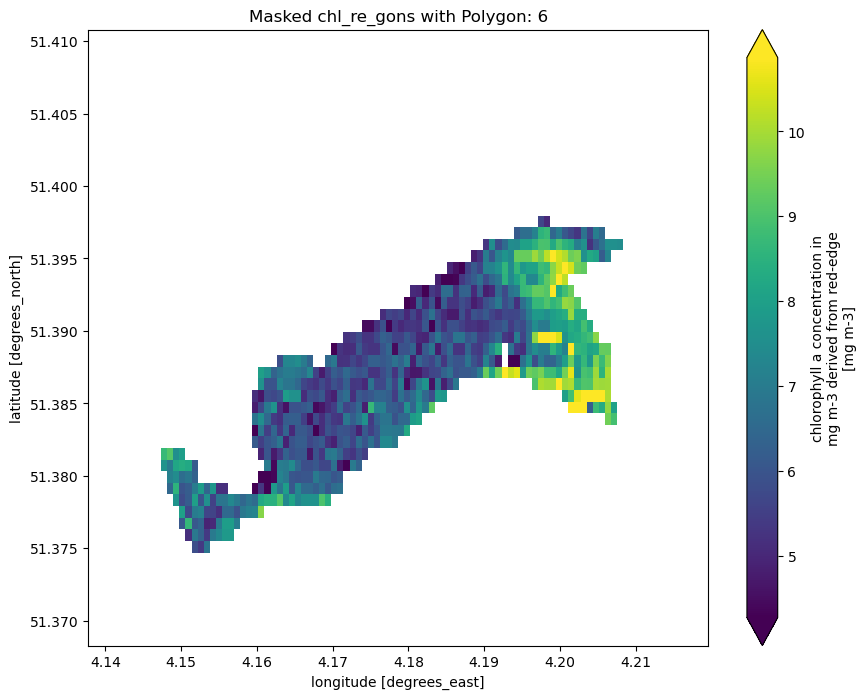

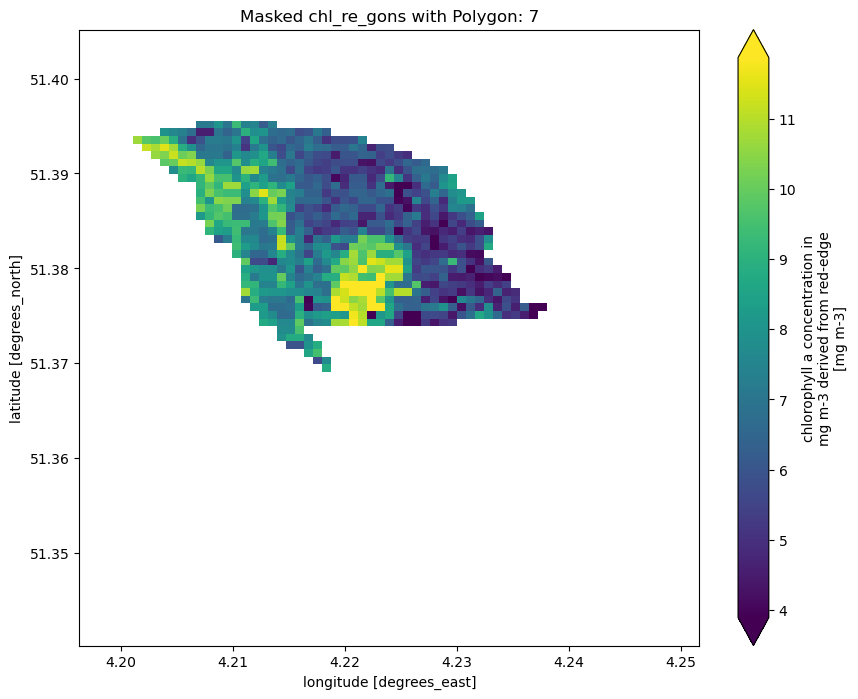

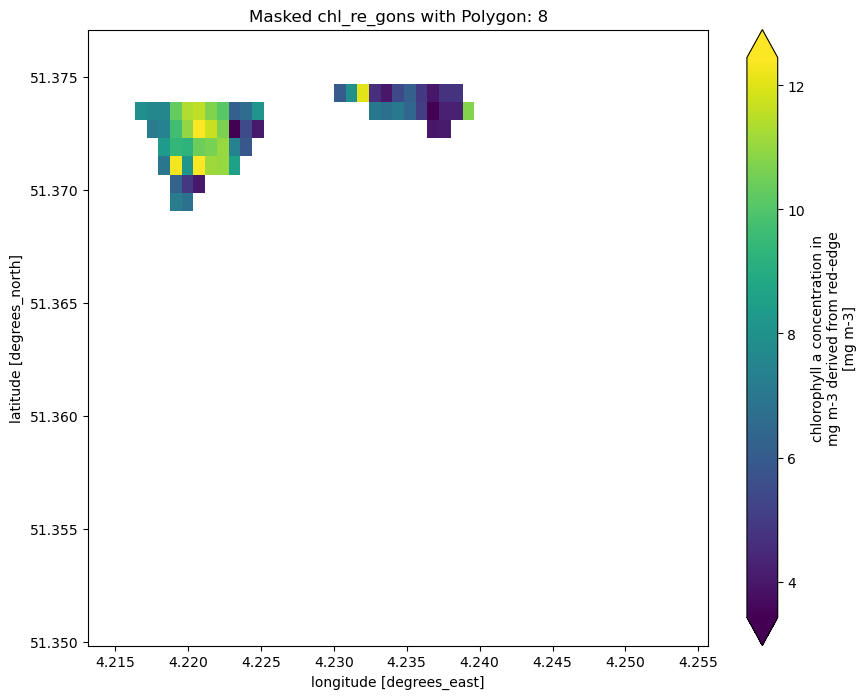

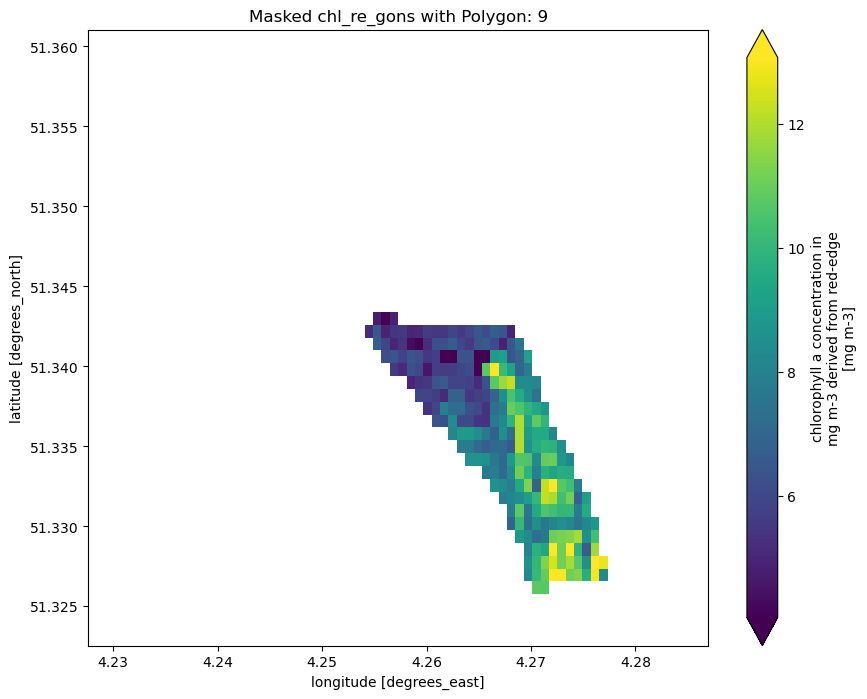

C:/Users/fuentesm/Marilu/Deltares/Projects/Westerchelde/Data/S2A_MSI_2023_08_23_10_56_47_merged_westerschelde_L2W.nc


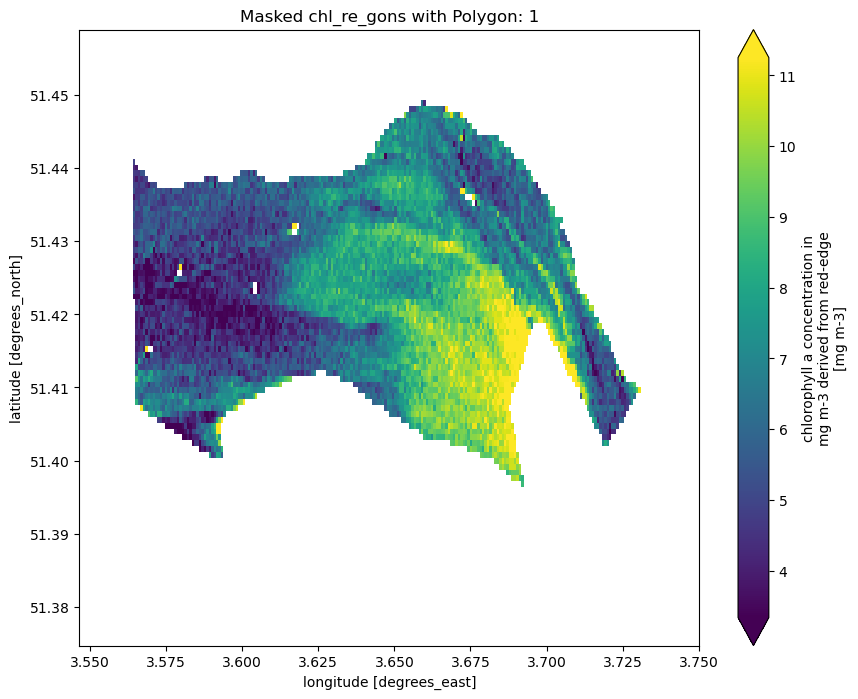

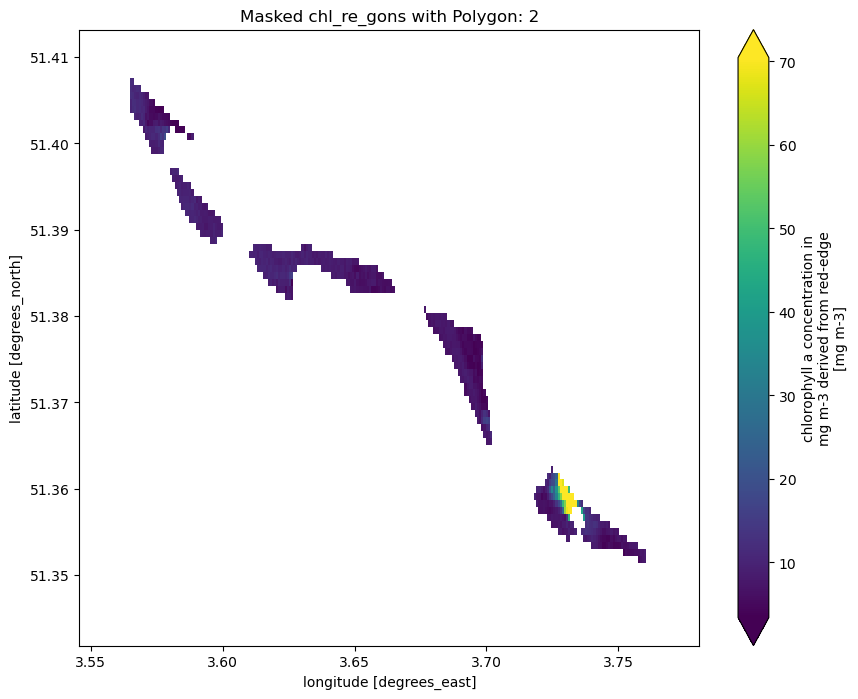

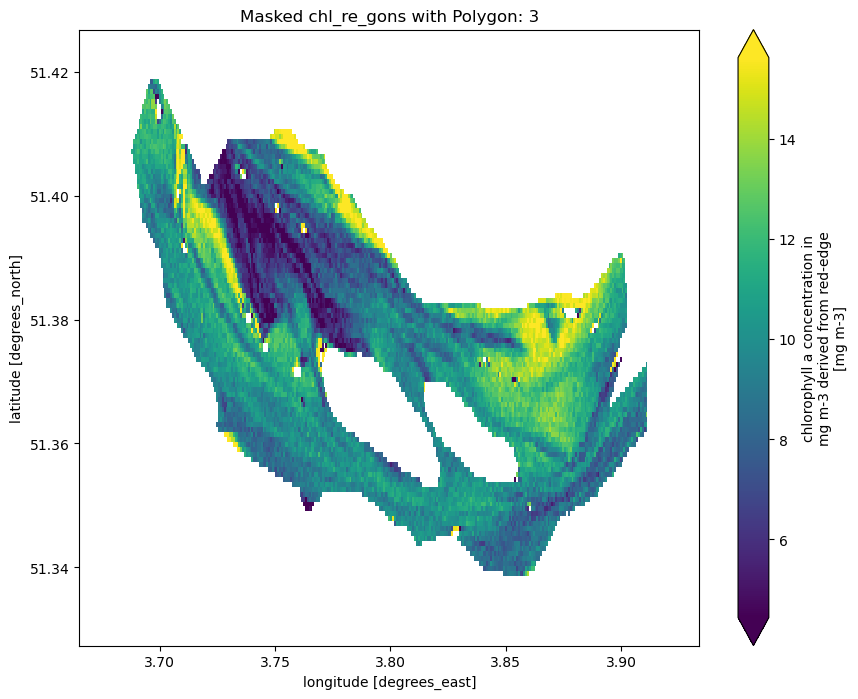

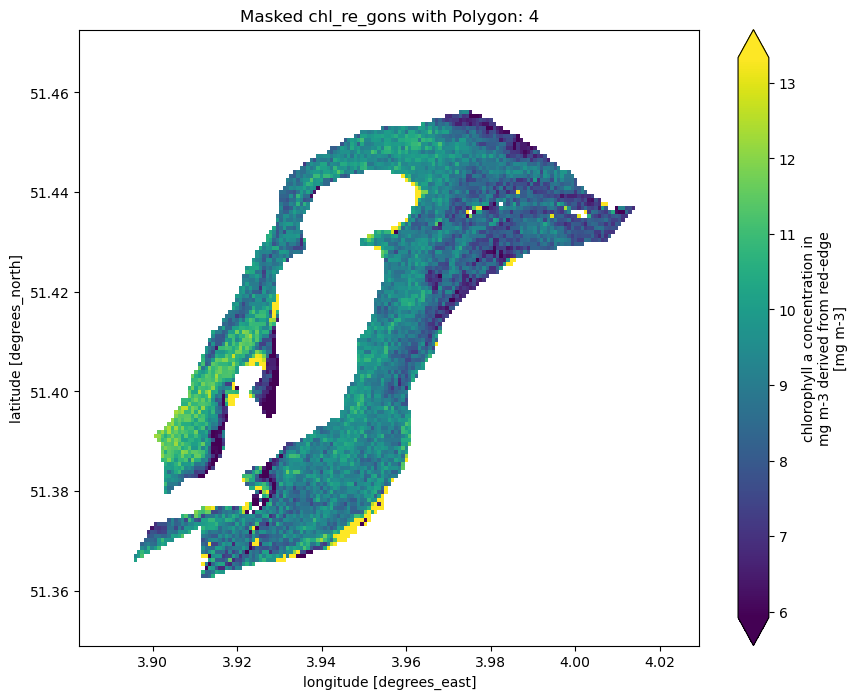

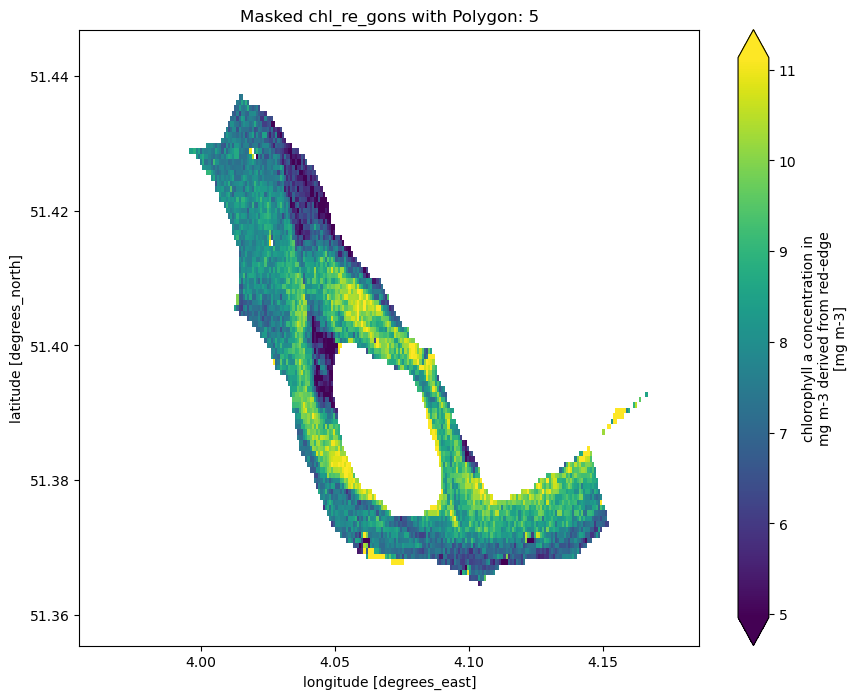

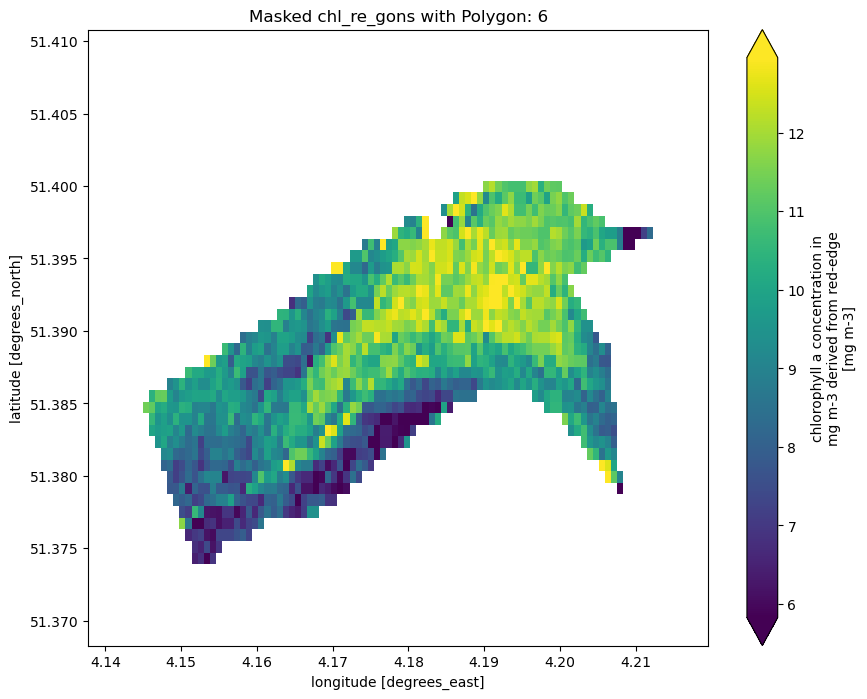

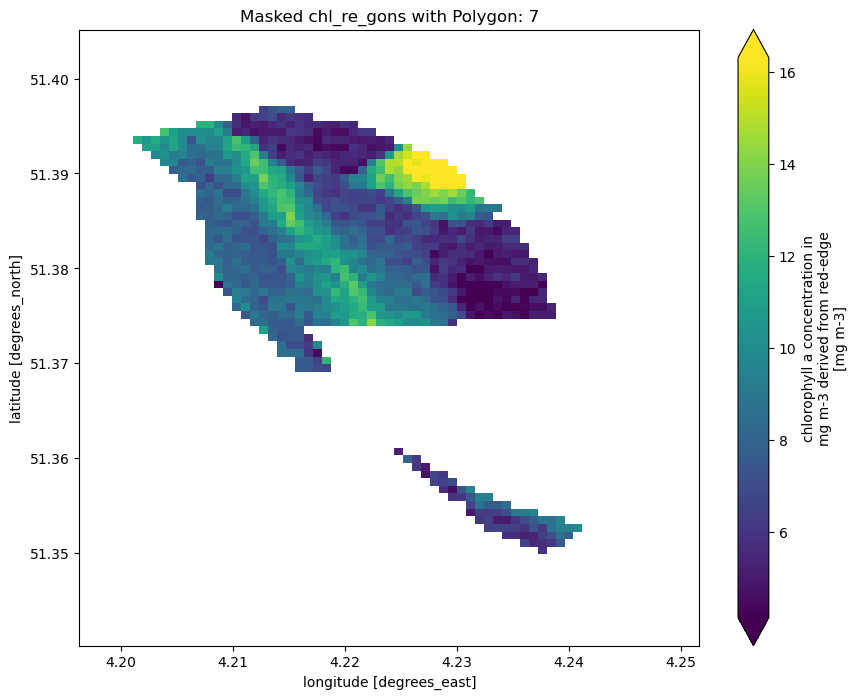

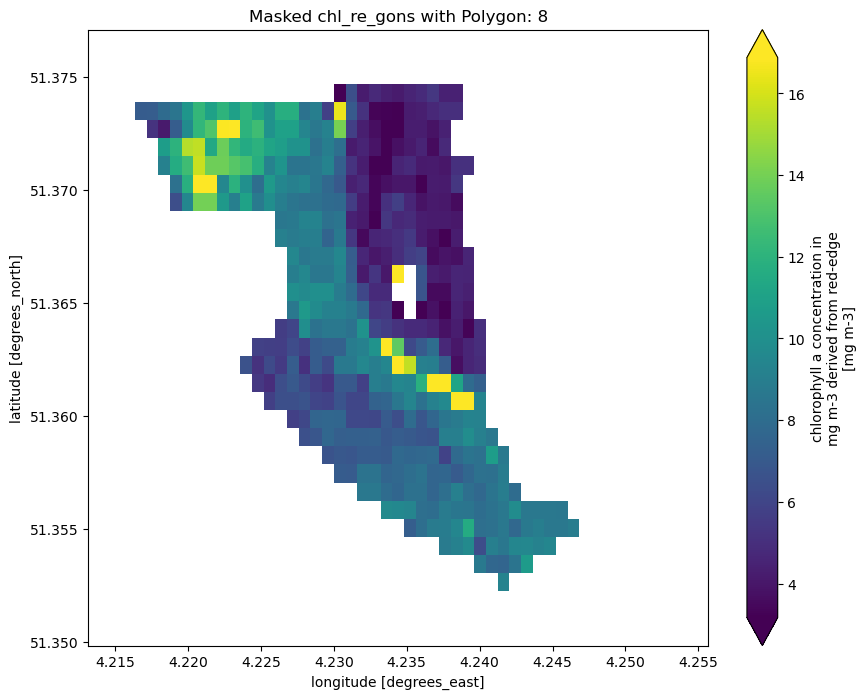

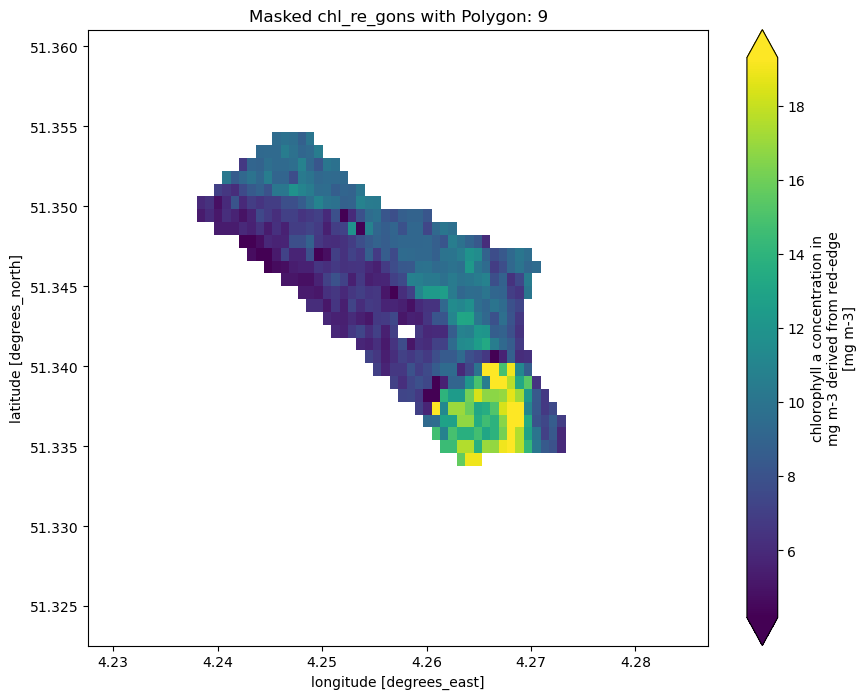


l2_flags

C:/Users/fuentesm/Marilu/Deltares/Projects/Westerchelde/Data/S2A_MSI_2015_07_16_10_50_24_merged_westerschelde_L2W.nc


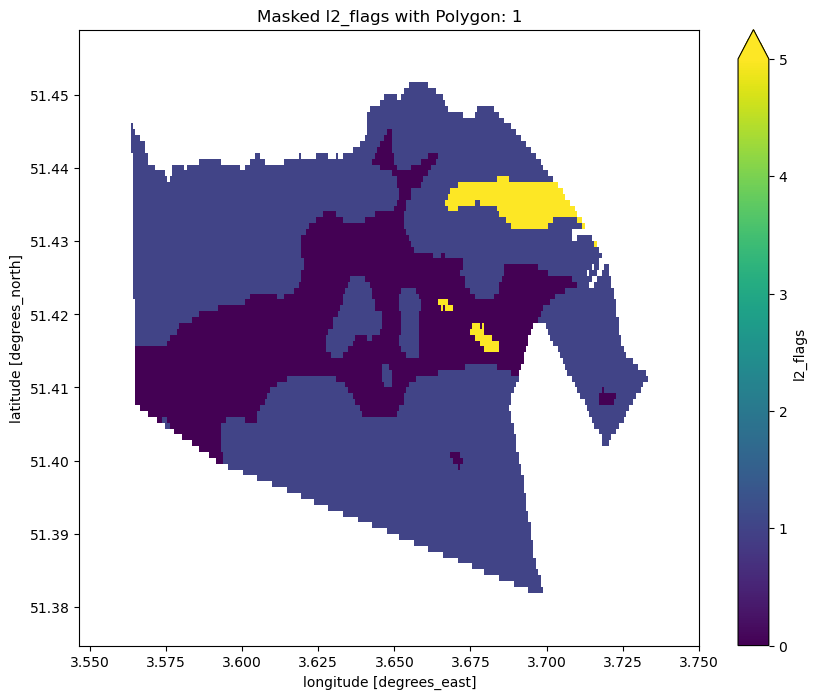

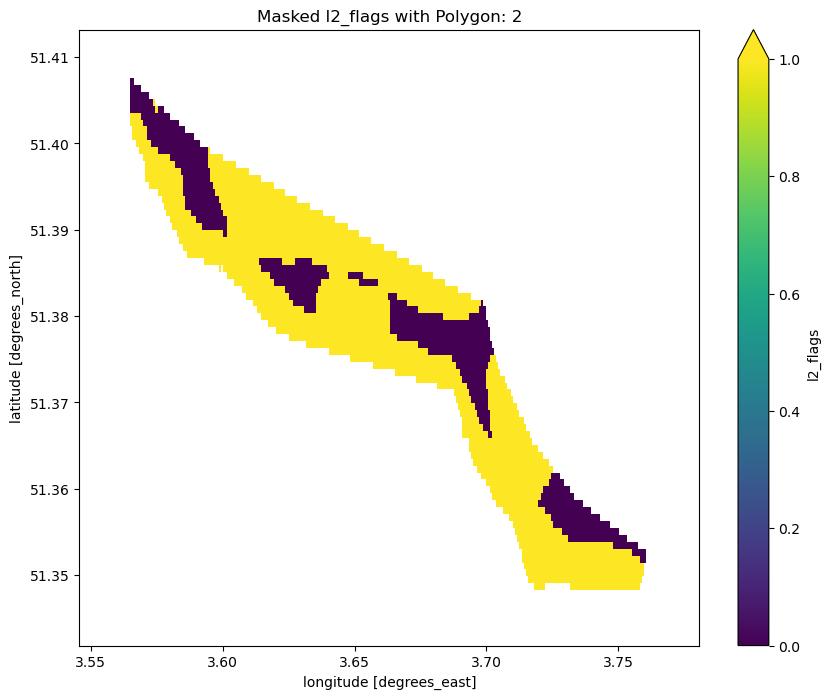

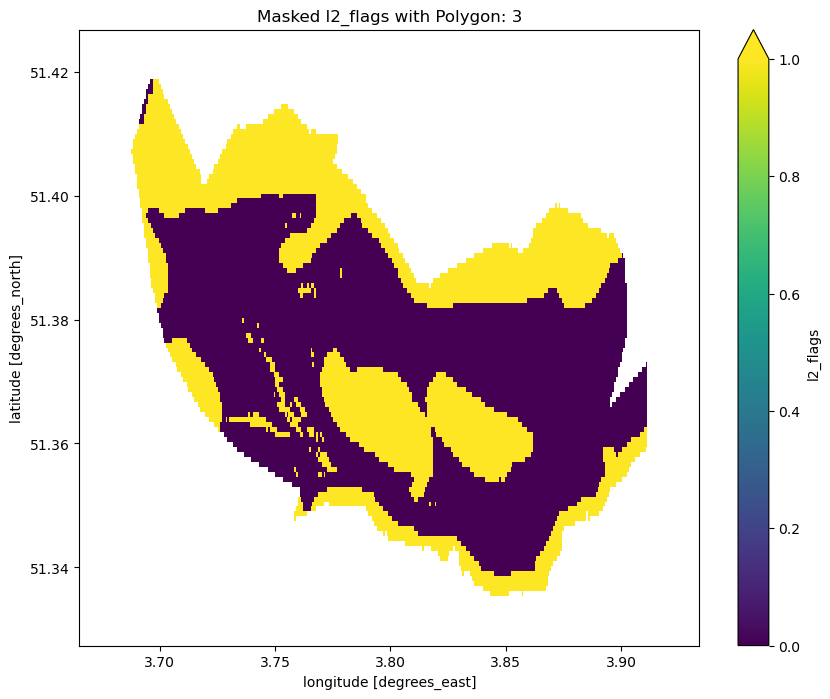

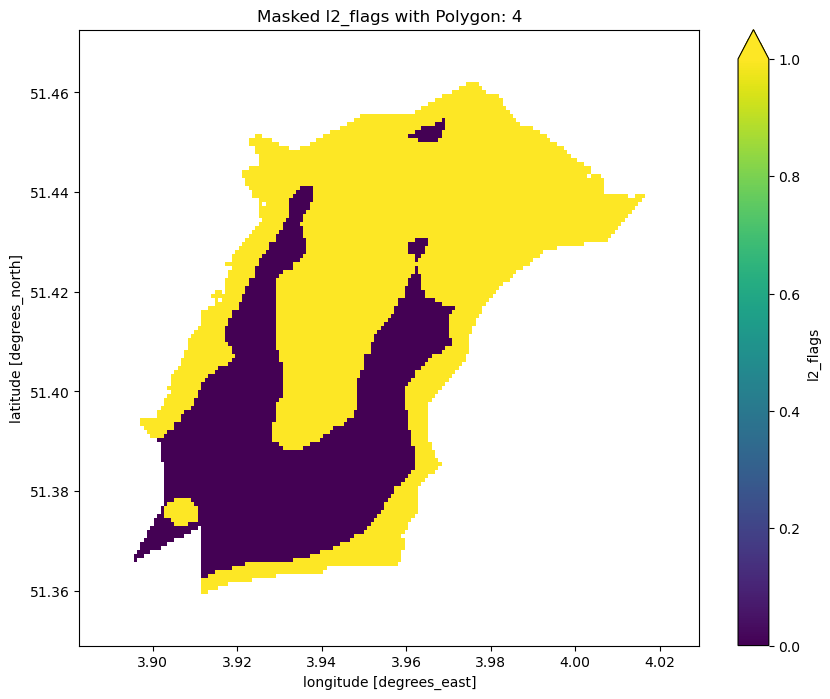

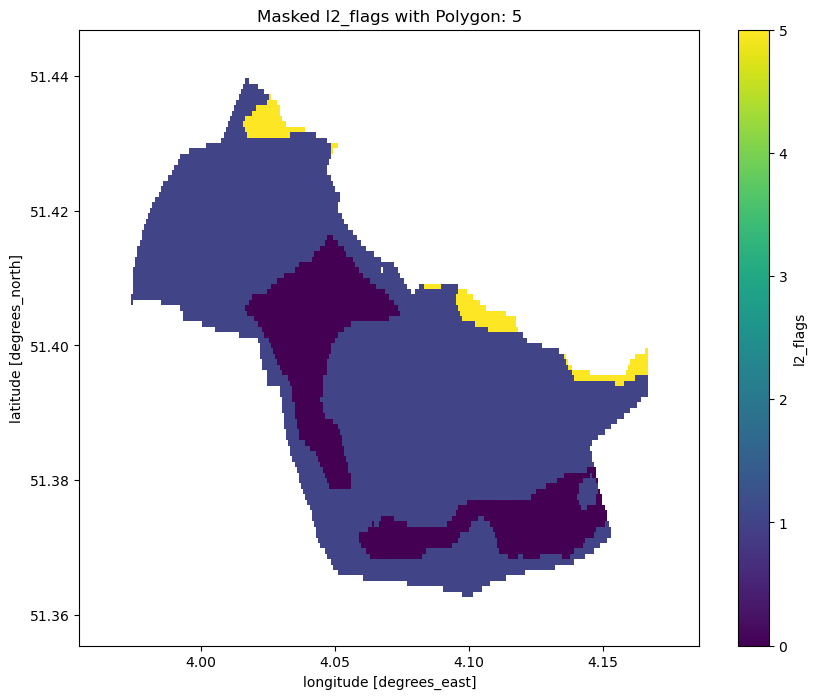

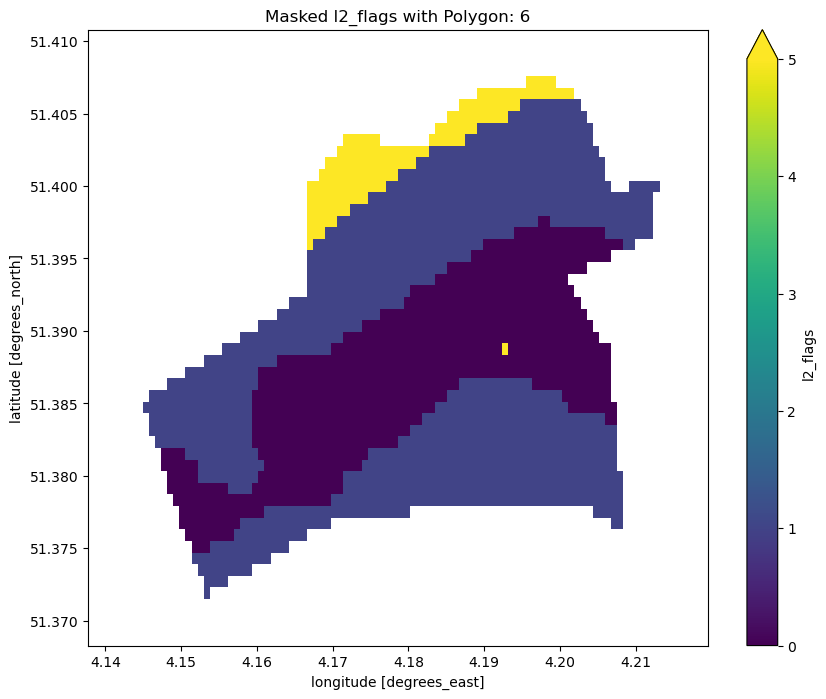

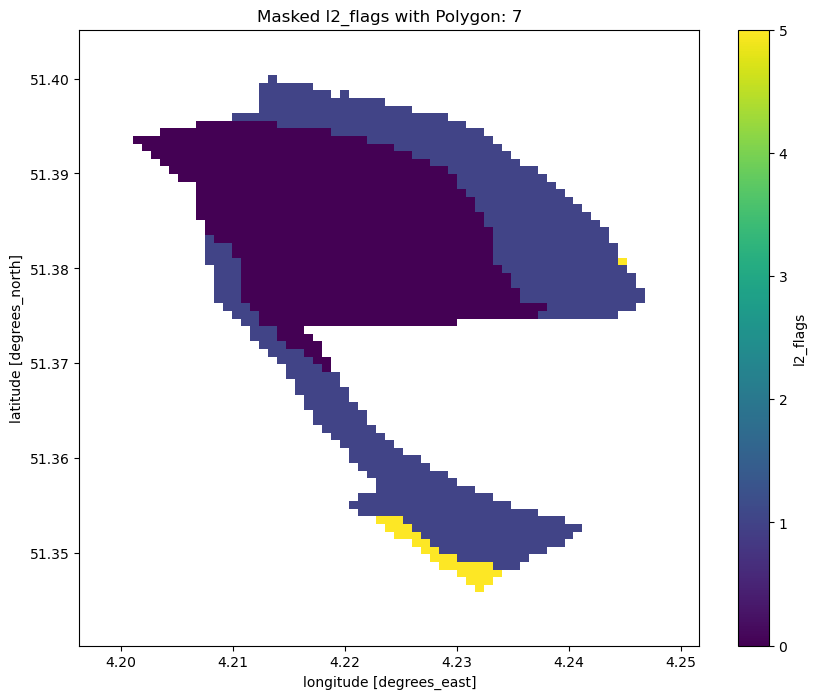

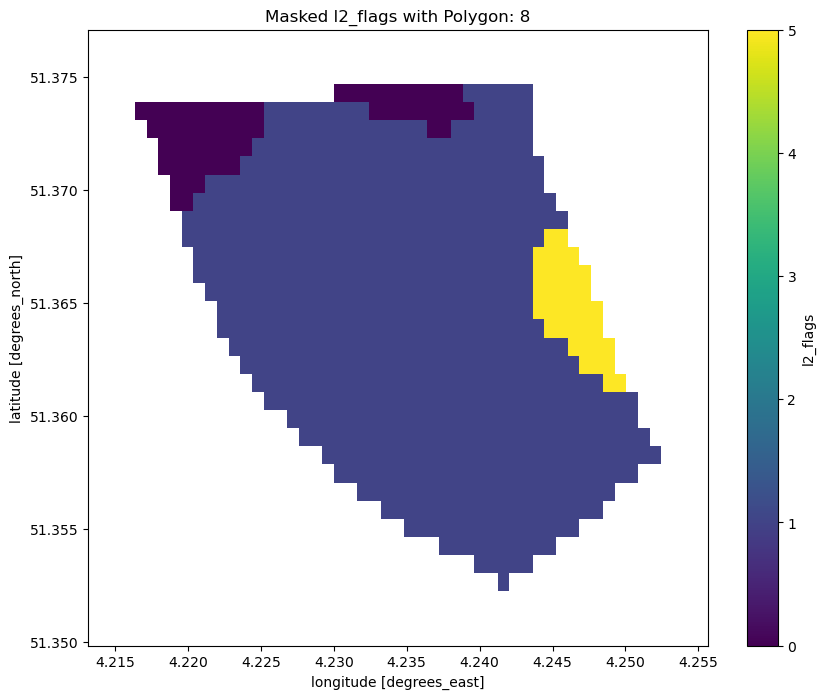

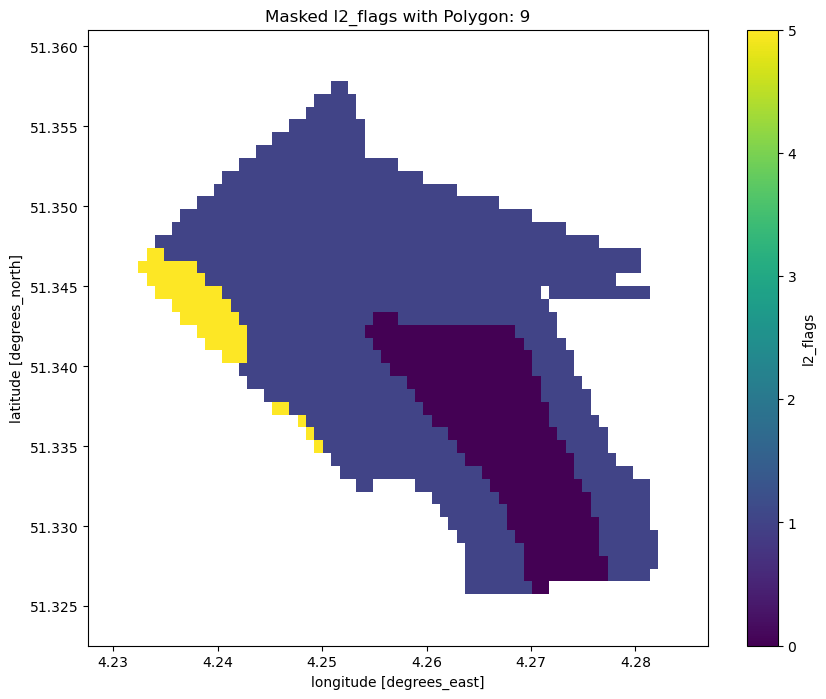

C:/Users/fuentesm/Marilu/Deltares/Projects/Westerchelde/Data/S2A_MSI_2023_08_23_10_56_47_merged_westerschelde_L2W.nc


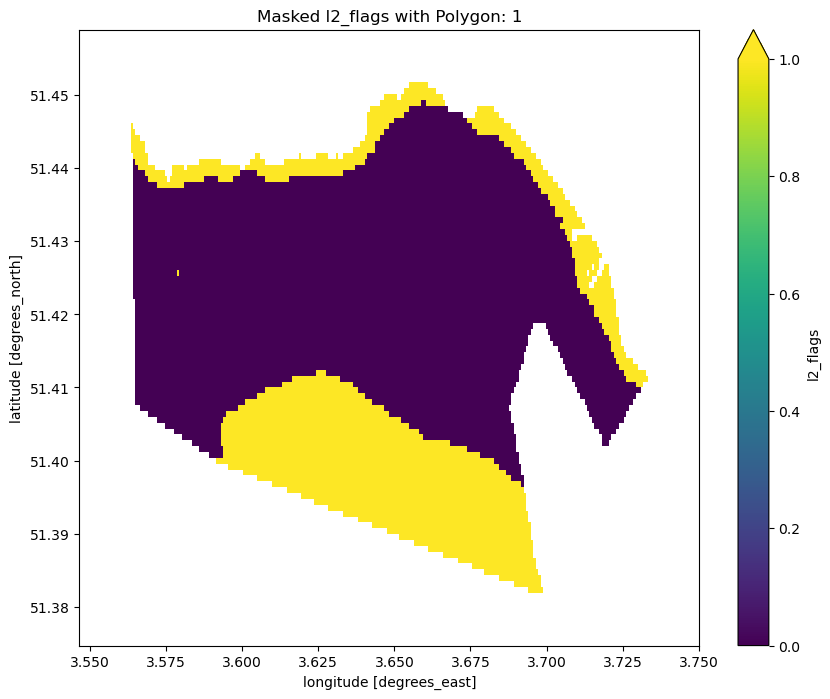

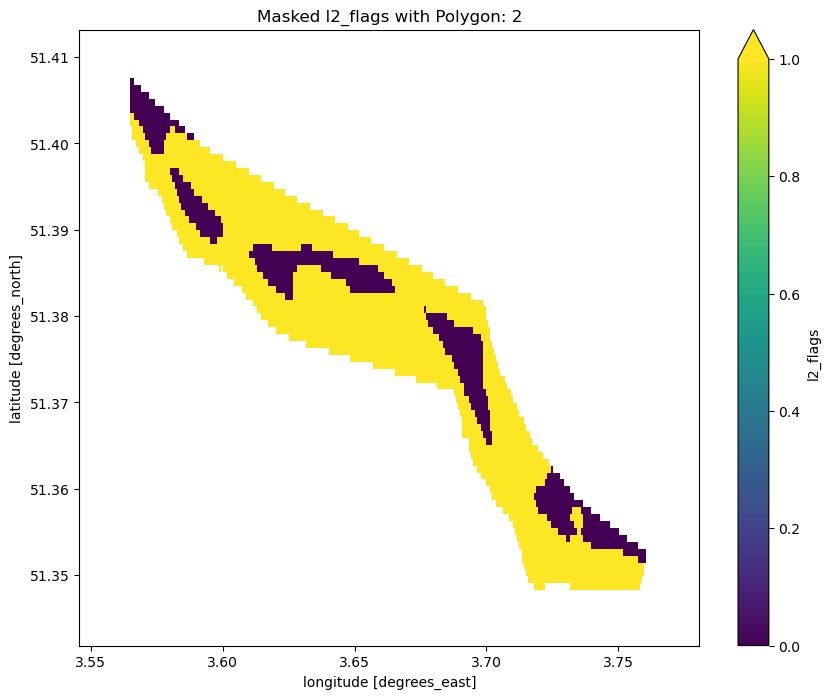

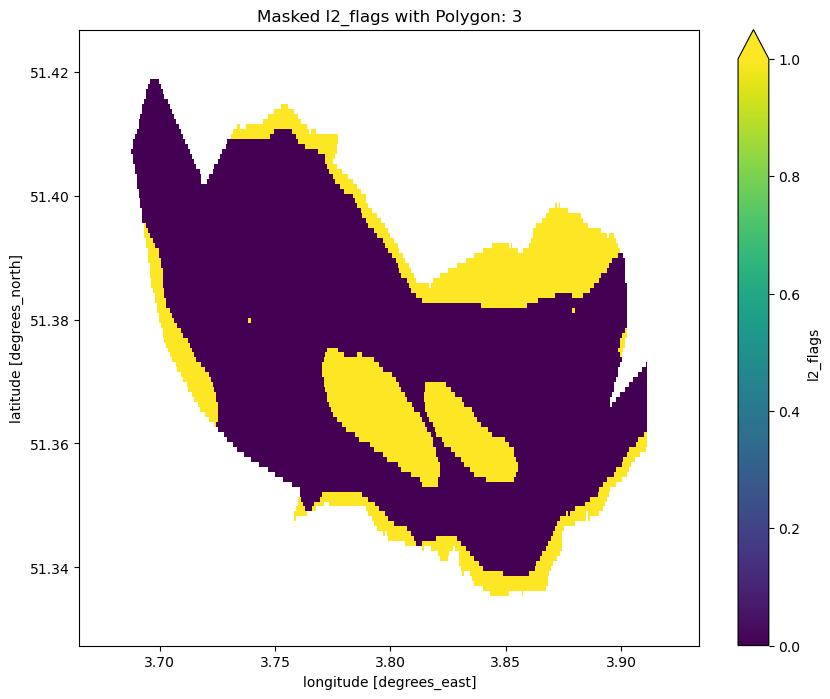

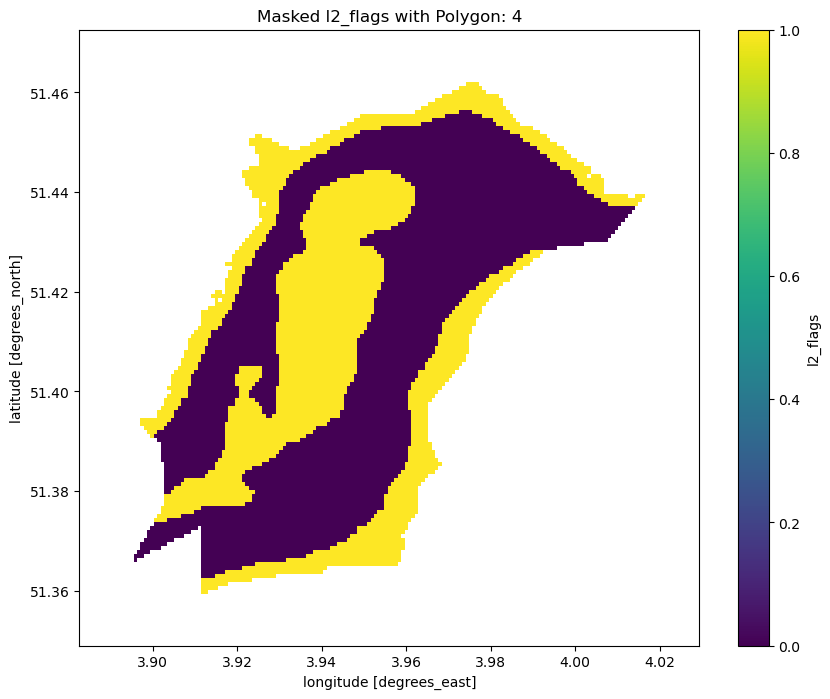

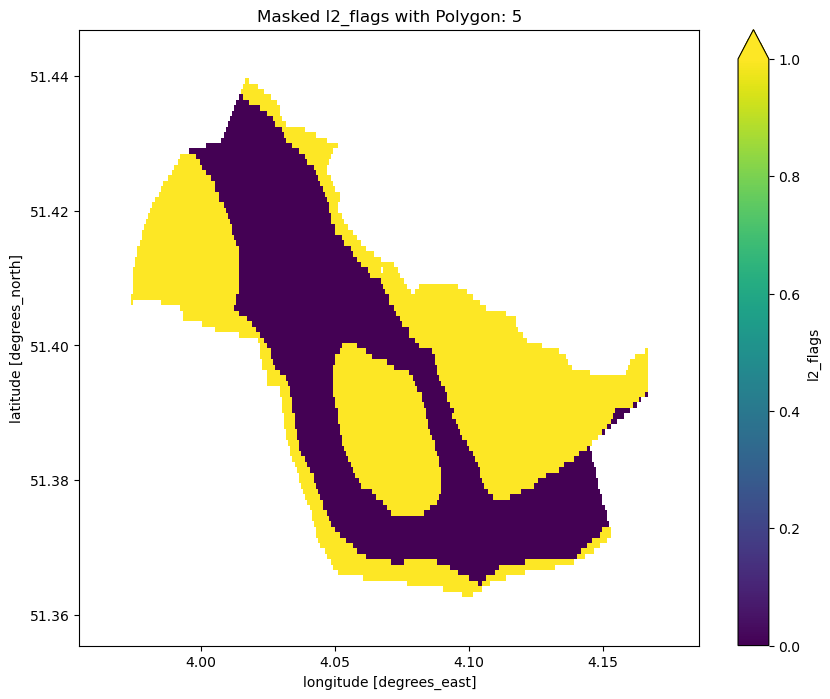

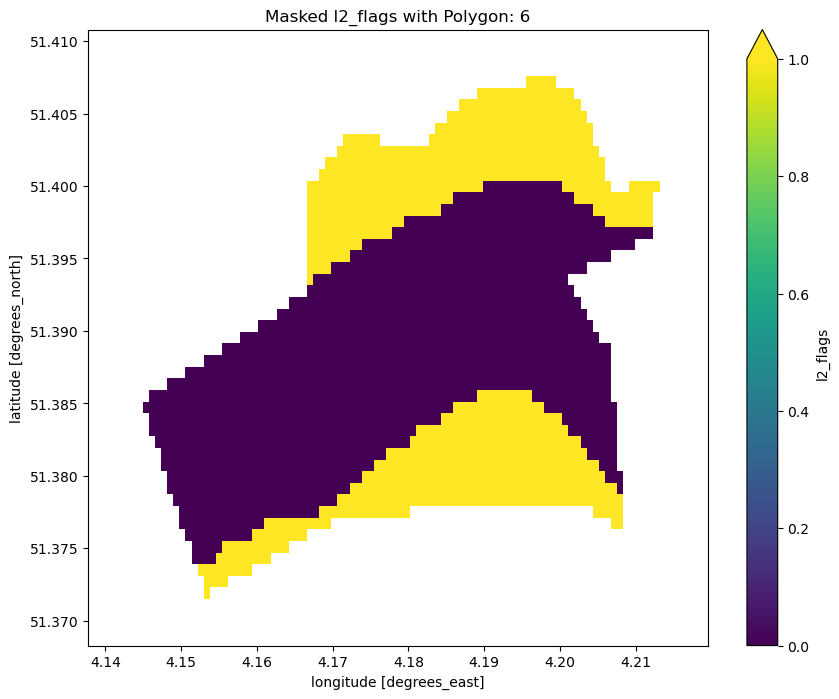

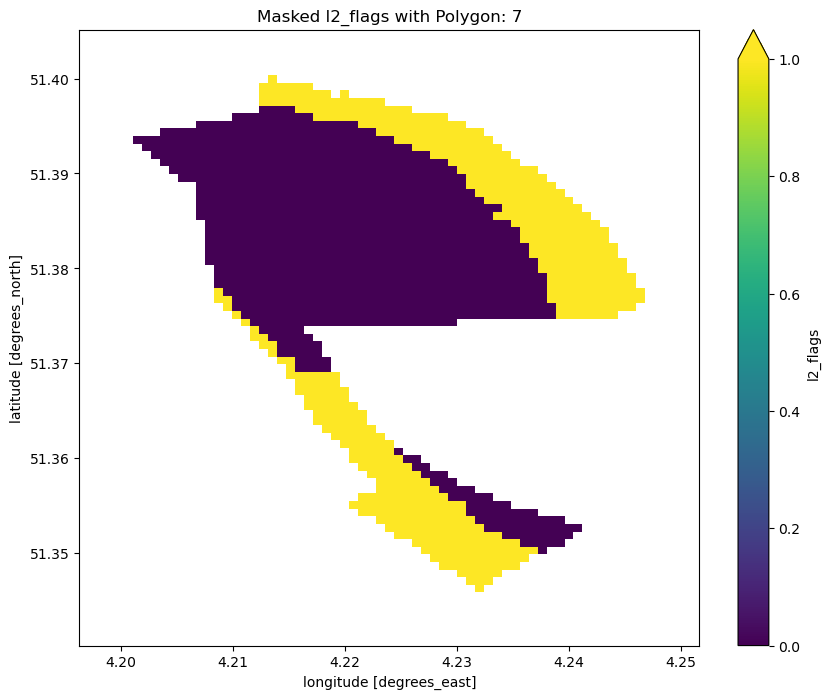

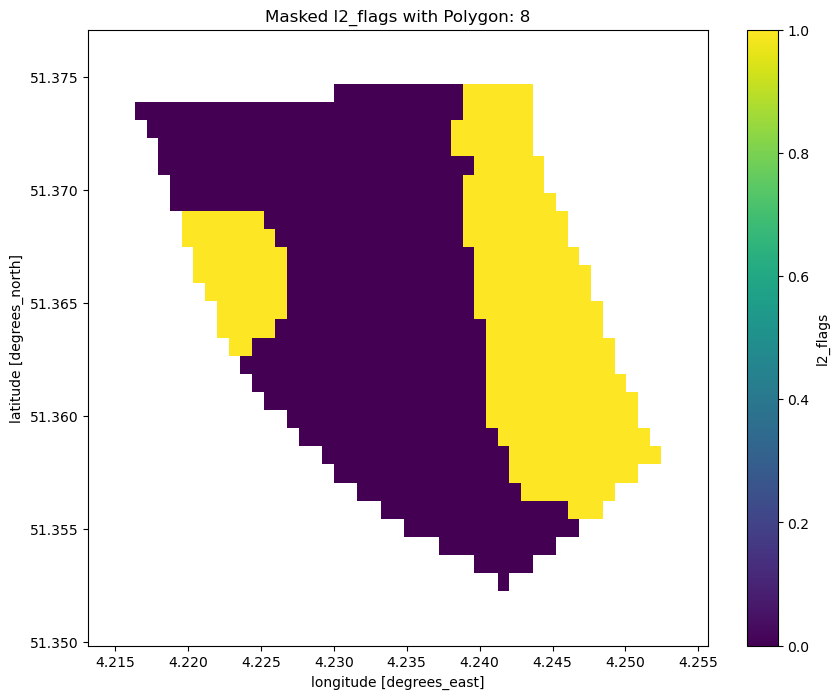

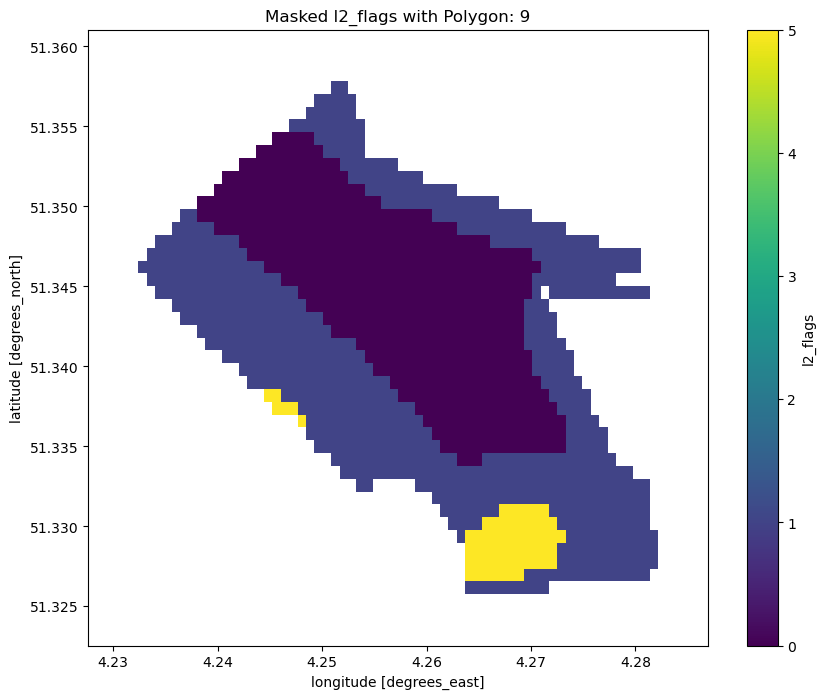

In [6]:
#Explore a folder with multiple L2W files and extracts pixel windows for a set of stations defined in a .csv files

import os
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import altair as alt
import numpy as np
import re
import psutil
import sys
import regionmask
import cf_xarray

from pyproj import CRS

# import dask.array as da

folder_path = 'C:/Users/fuentesm/Marilu/Deltares/Projects/Westerchelde/Data/'
folder_path_stations = 'C:/Users/fuentesm/Marilu/Deltares/Projects/Westerchelde/Data/Stations.xlsx' 
folder_path_shp = r'P:\11209243-eo\Geometries\geometries_NIOZ.shp'

def print_memory():
    # Get memory information
    memory_info = psutil.virtual_memory()

    # Print memory information
    # print(f"Total Memory: {memory_info.total / (1024 ** 3):.2f} GB")
    # print(f"Used Memory : {memory_info.used / (1024 ** 3):.2f} GB")
    # print(f"Free Memory : {memory_info.available / (1024 ** 3):.2f} GB")
    print(f"Memory Usage: {memory_info.percent:.2f}%")


# Define a function to extract the date from the path. Data abount the year
def extract_date(path):
    match = re.search(r'(\d{4}_\d{2}_\d{2})', path)
    if match:
        return match.group()
    else:
        return "0000_00_00"  # Return a default date if no date is found

# Define function to extract pixel values
def get_window(x_coord, y_coord, stationID, dataset):
    time_series   = dataset.sel(x=x_coord, y=y_coord, method='nearest')
    y_coord_exact = time_series['y'].values.tolist()
    x_coord_exact = time_series['x'].values.tolist()
    y_index = np.where(dataset['y'] == y_coord_exact)[0].tolist()[0]
    x_index = np.where(dataset['x'] == x_coord_exact)[0].tolist()[0]
    central_lon  = x_index
    central_lat  = y_index

    lat_start, lat_end = central_lat - 1, central_lat + 2
    lon_start, lon_end = central_lon - 1, central_lon + 2

    # window_values = da.from_array(dataset.isel(y=slice(lat_start, lat_end), x=slice(lon_start, lon_end)))
    # window_values = window_values.astype('float32')
    # window_values = window_values.compute()

    window_values = dataset.isel(y=slice(lat_start, lat_end), x=slice(lon_start, lon_end))
    window_values = window_values.expand_dims(station=[stationID])
    
    return window_values

# List all files in the folder
files_in_folder = os.listdir(folder_path)

# Filter the list to include only files ending with "ic.nc"
filtered_files = [file for file in files_in_folder if file.endswith("L2W.nc")]

# Sort the paths based on the extracted date
sorted_files = sorted(filtered_files, key=extract_date)

# Remove variables that are not used
variables_to_remove = ['transverse_mercator', 'x', 'y', 'lon', 'lat']

# Get variables names in a list. This component is hardcoded and is reading one S2A and one S2B image.
ds_a = xr.open_dataset(os.path.join(folder_path, sorted_files[0])).drop_vars(variables_to_remove)
ds_b = xr.open_dataset(os.path.join(folder_path, sorted_files[-1])).drop_vars(variables_to_remove)

variable_names_A = list(ds_a.variables)
variable_names_B = list(ds_b.variables)
variable_names = list(set(variable_names_A + variable_names_B))

print(variable_names_A)
print(variable_names_B)
print(variable_names)

# Reduce dataset for testing 
sorted_files = sorted_files[:]
variable_names =variable_names[:]

df_list = []
ds_list = []

for variable_name in variable_names:
    print('\n'+ variable_name+'\n')
    df = pd.read_excel(folder_path_stations)
    stations_list = []
    statistics = []

    for file in sorted_files:
        path = os.path.join(folder_path, file)
        print(path)

        # Open dataset
        dataset = xr.open_dataset(path)

        #dataset = xr.open_dataset(path, chunks={'x': 100, 'y': 100})
        crs_wkt = dataset.transverse_mercator.attrs['crs_wkt']
        crs = CRS.from_string(crs_wkt)

        dataset.rio.write_crs(crs.to_epsg(), inplace=True)
        dataset = dataset.rio.reproject('EPSG:4326')

        variables_to_remove = ['lon', 'lat']

        dataset =  dataset .drop_vars(variables_to_remove)
        dataset = dataset.rename({'x': 'lon', 'y': 'lat'})

        dataset   = dataset.reset_coords(['transverse_mercator'])
      
        polygons_gdf = gpd.read_file(folder_path_shp)
        polygons_gdf = polygons_gdf.to_crs('EPSG:4326')

        #Assign time component as a variable
        time_series = [datetime.fromisoformat(dataset.attrs.get("isodate"))]  
        ds = xr.concat([dataset[variable_name]], dim=xr.DataArray(time_series, coords={"time": time_series}, dims=["time"]))

        
        for index, row in polygons_gdf.iterrows():
            ksa_aoi  = polygons_gdf[polygons_gdf.Group == row['Group']]

            # Get coord bounds with buffer for clipping
            ksa_lat = [float(ksa_aoi.total_bounds[1]), float(ksa_aoi.total_bounds[3])]
            ksa_lon = [float(ksa_aoi.total_bounds[0]), float(ksa_aoi.total_bounds[2])]
            lat_multiplier = abs(ksa_lat[1] - ksa_lat[0])
            lon_multiplier = abs(ksa_lon[1] - ksa_lon[0])

            min_lon, max_lon = ksa_lon[0] - (0.1*lon_multiplier), ksa_lon[1] + (0.1*lon_multiplier)
            min_lat, max_lat = ksa_lat[0] - (0.1*lat_multiplier), ksa_lat[1] + (0.1*lat_multiplier)

            # Generate mask
            ksa_mask = regionmask.mask_geopandas(
                ksa_aoi, 
                ds.lon, 
                ds.lat)

            # Clip and mask
            ds_clip = ds.where((ds.lat <= max_lat) & (ds.lat >= min_lat)\
                            & (ds.lon <= max_lon) & (ds.lon >= min_lon), drop=True)
            ds_masked = ds_clip.where(~ksa_mask.isnull())

            # Calculate the mean value for the selected area
            mean_value = ds_masked.mean().values
            median_value = ds_masked.median().values
            min_value = ds_masked.min().values
            max_value = ds_masked.max().values
            std_value = ds_masked.std().values
            q25 = ds_masked.quantile(0.25).values
            q75 = ds_masked.quantile(0.75).values
            iqr_value = q75 - q25
            count_value = ds_masked.count().values
            # print("Mean Value:", mean_value)

            # Plot the masked DataArray
            plt.figure(figsize=(10, 8))
            ds_masked.isel(time=0).plot(cmap='viridis', robust=True)
            
            # Plot the polygons
            # polygons_gdf.plot(ax=plt.gca(), edgecolor='red')

            group = str(row['Group'])
            plt.title(f'Masked {variable_name} with Polygon: {group}')
            plt.show()

            statistics.append((time_series, row['Group'], mean_value, median_value, min_value, max_value, std_value, q25 , q75, iqr_value, count_value))

    df = pd.DataFrame({
        'Time': [coord[0][0]for coord in statistics],
        'Group': [coord[1] for coord in statistics],
        variable_name +'_mean': [coord[2].round(decimals=4) for coord in statistics],
        # variable_name +'_median': [coord[3].round(decimals=4) for coord in statistics],
        variable_name +'_min': [coord[4].round(decimals=4) for coord in statistics],
        variable_name +'_max': [coord[5].round(decimals=4) for coord in statistics],
        variable_name +'_std': [coord[6].round(decimals=4) for coord in statistics],
        variable_name +'_q25': [coord[7].round(decimals=4) for coord in statistics],
        variable_name +'_q75': [coord[8].round(decimals=4) for coord in statistics],
        variable_name +'_iqr': [coord[9].round(decimals=4) for coord in statistics],
        variable_name +'_count': [coord[10] for coord in statistics],
    })

    df['ID'] =  df['Time'].dt.strftime('%Y_%m_%d') + '_' + df['Group'].round().astype(int).astype(str) 

    # df.set_index('Time', inplace=True)

    df_list.append(df)

# Create a single table 
merged_df = df_list[0].iloc[:,2:]  

for df in df_list[1:]:
    merged_df = pd.merge(merged_df, df.iloc[:,2:], on='ID', how='outer')

split_columns = merged_df['ID'].str.split('_', expand=True)
merged_df.insert(0, 'Year', split_columns[0].astype(str))
merged_df.insert(1, 'Month', split_columns[1].astype(str))
merged_df.insert(2, 'Day', split_columns[2].astype(str))
merged_df.insert(3, 'Group', split_columns[3].astype(str))

merged_df.insert(4, 'Date', pd.to_datetime(merged_df[['Year', 'Month', 'Day']], errors='coerce').dt.date)

merged_df = merged_df.replace('nan', np.nan)
merged_df.set_index('ID', inplace=True)
excel_output_path = 'full_area_value.xlsx' 
merged_df.to_excel(excel_output_path,na_rep='nan')


In [7]:
# stationID = 'S1'
# station = 'SCHAARVODDL	Schaar van Ouden Doel'
# lon = 4.250932603
# lat = 51.35118367
# x_coord =  5.8711167e+05 #5.208e+05  
# y_coord =  5.68962179e+06

# stationID = 'S2'
# station = 'VLISSGNLDK	Vlissingen Nolledijk'
# lon = 3.553066,	
# lat = 51.450453
# x_coord =  5.3843131e+05   
# y_coord =  5.70006397e+06 

In [8]:
#Explore a folder with multiple L2W files and extracts pixel windows for a set of stations defined in a .csv files

import os
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import altair as alt
import numpy as np
import re
import psutil
import sys
# import dask.array as da

folder_path = 'C:/Users/fuentesm/Marilu/Deltares/Projects/Westerchelde/Data/'
folder_path_stations = 'C:/Users/fuentesm/Marilu/Deltares/Projects/Westerchelde/Data/Stations.xlsx' 

def print_memory():
    # Get memory information
    memory_info = psutil.virtual_memory()

    # Print memory information
    # print(f"Total Memory: {memory_info.total / (1024 ** 3):.2f} GB")
    # print(f"Used Memory : {memory_info.used / (1024 ** 3):.2f} GB")
    # print(f"Free Memory : {memory_info.available / (1024 ** 3):.2f} GB")
    print(f"Memory Usage: {memory_info.percent:.2f}%")


# Define a function to extract the date from the path. Data abount the year
def extract_date(path):
    match = re.search(r'(\d{4}_\d{2}_\d{2})', path)
    if match:
        return match.group()
    else:
        return "0000_00_00"  # Return a default date if no date is found

# Define function to extract pixel values
def get_window(x_coord, y_coord, stationID, dataset):
    time_series   = dataset.sel(x=x_coord, y=y_coord, method='nearest')
    y_coord_exact = time_series['y'].values.tolist()
    x_coord_exact = time_series['x'].values.tolist()
    y_index = np.where(dataset['y'] == y_coord_exact)[0].tolist()[0]
    x_index = np.where(dataset['x'] == x_coord_exact)[0].tolist()[0]
    central_lon  = x_index
    central_lat  = y_index

    lat_start, lat_end = central_lat - 1, central_lat + 2
    lon_start, lon_end = central_lon - 1, central_lon + 2

    # window_values = da.from_array(dataset.isel(y=slice(lat_start, lat_end), x=slice(lon_start, lon_end)))
    # window_values = window_values.astype('float32')
    # window_values = window_values.compute()

    window_values = dataset.isel(y=slice(lat_start, lat_end), x=slice(lon_start, lon_end))
    window_values = window_values.expand_dims(station=[stationID])
    
    return window_values

# List all files in the folder
files_in_folder = os.listdir(folder_path)

# Filter the list to include only files ending with "ic.nc"
filtered_files = [file for file in files_in_folder if file.endswith("L2W.nc")]

# Sort the paths based on the extracted date
sorted_files = sorted(filtered_files, key=extract_date)

variables_to_remove = ['transverse_mercator', 'x', 'y', 'lon', 'lat']
ds = xr.open_dataset(os.path.join(folder_path, sorted_files[0]))
ds= ds.drop_vars(variables_to_remove)

variable_names_A = list(ds.variables)
print(variable_names_A)

ds = xr.open_dataset(os.path.join(folder_path, sorted_files[-1]))
ds= ds.drop_vars(variables_to_remove)

variable_names_B = list(ds.variables)
variable_names_B
print(variable_names_B)

variable_names = list(set(variable_names_A + variable_names_B))
print(variable_names)

# For testing 
sorted_files = sorted_files[:]
variable_names =variable_names[:]

df_list = []
ds_list = []

for variable_name in variable_names:
    print('\n'+ variable_name+'\n')
    df = pd.read_excel(folder_path_stations)
    stations_list = []

    for file in sorted_files:
        path = os.path.join(folder_path, file)
        print(path)

        dataset = xr.open_dataset(path, chunks={'x': 100, 'y': 100})

        time_series = [datetime.fromisoformat(dataset.attrs.get("isodate"))]  # Replace with your time series data
        
        try:
            dataset = xr.concat([dataset[variable_name]], dim=xr.DataArray(time_series, coords={"time": time_series}, dims=["time"]))
            
            for index, row in df.iterrows():

                station_window = get_window(row['x_coord'], row['y_coord'], row['stationID'],dataset)
                stations_list.append(station_window)
                del station_window    
            
            print(f"Memory usage of dataset: {sys.getsizeof(dataset)} bytes")
            print_memory()   
            del dataset 

        except Exception as e:
            print(f"Error with {file}: {e}")
            continue  

    # Create a single netcdf with all the data

    merged_stations = xr.concat(stations_list, dim='station').groupby('station').max(dim='station')
    del stations_list

    # Get the latitude and longitude coordinates
    latitudes = merged_stations['y'].values
    longitudes = merged_stations['x'].values
    times = merged_stations['time'].values
    stations = merged_stations['station'].values

    # Initialize lists to store data
    pixel_values = []
    coordinates = []

    # Iterate over latitudes and longitudes
    for station_index, station in enumerate(stations):
        print(station)
        for time_index, time in enumerate(times):
            for lat_index, lat in enumerate(latitudes):
                for lon_index, lon in enumerate(longitudes):
                    
                    # Extract pixel value
                    ##pixel_value = merged_stations[variable_name].isel(y=lat_index, x=lon_index, time=time_index, station=station_index).values.item()
                    pixel_value = merged_stations.sel(station=station).isel(y=lat_index, x=lon_index, time=time_index).values

                    time = pd.Timestamp(time).tz_localize(None)

                    # Append data to lists
                    pixel_values.append(pixel_value)
                    coordinates.append((lat, lon, station, time))

    df = pd.DataFrame({
        'Latitude': [coord[0] for coord in coordinates],
        'Longitude': [coord[1] for coord in coordinates],
        'Station': [coord[2] for coord in coordinates],
        'Time': [coord[3] for coord in coordinates],
        variable_name: pixel_values
    })

    df['ID'] =  df['Latitude'].round().astype(int).astype(str) + '_' + df['Longitude'].round().astype(int).astype(str) + '_' + df['Station'] + '_' + df['Time'].dt.strftime('%Y_%m_%d')

    # Save processed data. Excel file and netcdf

    # merged_stations['time'] = merged_stations['time'].astype('datetime64')
    # output_file_path = variable_name + '_file.nc'
    # merged_stations.to_netcdf(output_file_path)

    # excel_output_path = variable_name + '_pixel_windows_value.xlsx' #This miss to integrate extra columns with metadata (e.g. station ID)
    # df.to_excel(excel_output_path, index=False)

    ds_list.append(merged_stations)
    df_list.append(df)

    print(f"Memory usage of ds_list: {sys.getsizeof(ds_list)} bytes")
    print(f"Memory usage of df_list: {sys.getsizeof(df_list)} bytes")

    del merged_stations
    del df

# Create a single table 
merged_df = df_list[0].iloc[:,4:6]  

for df in df_list[1:]:
    #merged_df = pd.merge(merged_df, df.iloc[:,4:5], left_index=True, right_index=True, how='left')
    merged_df = pd.merge(merged_df, df.iloc[:,4:6], on='ID', how='outer')

merged_ds =xr.merge(ds_list)
merged_ds['time'] = merged_ds['time'].astype('datetime64')

output_file_path =  'full_file.nc'
merged_ds.to_netcdf(output_file_path)

split_columns = merged_df['ID'].str.split('_', expand=True)
merged_df.insert(0, 'Latitude', split_columns[0].astype(float))
merged_df.insert(1, 'Longitude', split_columns[1].astype(float))
merged_df.insert(2, 'Station', split_columns[2].astype(str))
merged_df.insert(3, 'Year', split_columns[3].astype(str))
merged_df.insert(4, 'Month', split_columns[4].astype(str))
merged_df.insert(5, 'Day', split_columns[5].astype(str))

merged_df.insert(6, 'Date', pd.to_datetime(merged_df[['Year', 'Month', 'Day']], errors='coerce').dt.date)

merged_df = merged_df.replace('nan', np.nan)
merged_df.set_index('ID', inplace=True)
excel_output_path = 'full_pixel_windows_value.xlsx' #This miss to integrate extra columns with metadata (e.g. station ID)
merged_df.to_excel(excel_output_path,na_rep='nan')

['l2_flags', 'chl_re_gons']
['l2_flags', 'chl_re_gons']
['chl_re_gons', 'l2_flags']

chl_re_gons

C:/Users/fuentesm/Marilu/Deltares/Projects/Westerchelde/Data/S2A_MSI_2015_07_16_10_50_24_merged_westerschelde_L2W.nc
Memory usage of dataset: 96 bytes
Memory Usage: 46.70%
C:/Users/fuentesm/Marilu/Deltares/Projects/Westerchelde/Data/S2A_MSI_2023_08_23_10_56_47_merged_westerschelde_L2W.nc
Memory usage of dataset: 96 bytes
Memory Usage: 46.70%
0
1
2
3
4
5


TypeError: can only concatenate str (not "int") to str